<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
        Project - 3rd Phase
        <br />
        Image Colorization using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = 99106255
            <br />
            Name = Alireza
            <br />
            Last_Name = Shokrani
        </div>
        <div class="column">
        <br />
            student_number = 99105901
            <br />
            Name = Amirhossein  
            <br />
            Last_Name = Akbari
        </div>
    </font>
    </div>


1. Download the "landscape image colorization" dataset and slice it to `train_set`, `validation_set` and `test_set`.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to colorize grayscale images
3. plot learning curve and visualize grayscale images of test set, their corresponding color images and their colorized versions side by side.

# Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageCms
from torch.utils.data import Dataset
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from skimage.color import lab2rgb
from skimage import io

In [2]:
# shutil.rmtree('/content/landscape Images')

# Load Dataset and Prepare It

In [3]:
! pip install kaggle
#--------------------
! mkdir ~/.kaggle
#--------------------
! cp kaggle.json ~/.kaggle/
#--------------------
! chmod 600 ~/.kaggle/kaggle.json
#--------------------
! kaggle datasets download theblackmamba31/landscape-image-colorization
#--------------------
! unzip /content/landscape-image-colorization.zip

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

In [4]:
# Set the directory for the "landscape Images" folder
base_dir = '/content/landscape Images'

# Set the directories for the "color" and "gray" folders
color_dir = os.path.join(base_dir, 'color')
gray_dir = os.path.join(base_dir, 'gray')

# Create lists of the image filenames in the "color" and "gray" folders
color_images = os.listdir(color_dir)
gray_images = os.listdir(gray_dir)

# Split the data into training, validation, and test sets (80%, 15%, 5%)
train_color, test_color = train_test_split(color_images, test_size=0.2, random_state=1)
test_color, val_color = train_test_split(test_color, test_size=0.25, random_state=1)

train_gray, test_gray = train_test_split(gray_images, test_size=0.2, random_state=1)
test_gray, val_gray = train_test_split(test_gray, test_size=0.25, random_state=1)

# Create directories for the training, validation, and test sets
train_color_dir = os.path.join(base_dir, 'train', 'color')
val_color_dir = os.path.join(base_dir, 'val', 'color')
test_color_dir = os.path.join(base_dir, 'test', 'color')

train_gray_dir = os.path.join(base_dir, 'train', 'gray')
val_gray_dir = os.path.join(base_dir, 'val', 'gray')
test_gray_dir = os.path.join(base_dir, 'test', 'gray')

l_train_dir = os.path.join(train_color_dir, "L")
a_train_dir = os.path.join(train_color_dir, "A")
b_train_dir = os.path.join(train_color_dir, "B")

l_val_dir = os.path.join(val_color_dir, "L")
a_val_dir = os.path.join(val_color_dir, "A")
b_val_dir = os.path.join(val_color_dir, "B")

l_test_dir = os.path.join(test_color_dir, "L")
a_test_dir = os.path.join(test_color_dir, "A")
b_test_dir = os.path.join(test_color_dir, "B")


os.makedirs(train_color_dir)
os.makedirs(val_color_dir)
os.makedirs(test_color_dir)

os.makedirs(train_gray_dir)
os.makedirs(val_gray_dir)
os.makedirs(test_gray_dir)

os.makedirs(l_train_dir, exist_ok=True)
os.makedirs(a_train_dir, exist_ok=True)
os.makedirs(b_train_dir, exist_ok=True)

os.makedirs(l_val_dir, exist_ok=True)
os.makedirs(a_val_dir, exist_ok=True)
os.makedirs(b_val_dir, exist_ok=True)

os.makedirs(l_test_dir, exist_ok=True)
os.makedirs(a_test_dir, exist_ok=True)
os.makedirs(b_test_dir, exist_ok=True)

srgb_p = ImageCms.createProfile("sRGB")
lab_p  = ImageCms.createProfile("LAB")
rgb2lab = ImageCms.buildTransformFromOpenProfiles(srgb_p, lab_p, "RGB", "LAB")

# Copy the images to the appropriate directories
for image in train_color:
    src = os.path.join(color_dir, image)
    dst = os.path.join(train_color_dir, image)
    shutil.copyfile(src, dst)
    lab = ImageCms.applyTransform(Image.open(dst), rgb2lab)
    l_channel, a_channel, b_channel = lab.split()
    l_channel.save(os.path.join(l_train_dir, image))
    a_channel.save(os.path.join(a_train_dir, image))
    b_channel.save(os.path.join(b_train_dir, image))

for image in val_color:
    src = os.path.join(color_dir, image)
    dst = os.path.join(val_color_dir, image)
    shutil.copyfile(src, dst)
    lab = ImageCms.applyTransform(Image.open(dst), rgb2lab)
    l_channel, a_channel, b_channel = lab.split()
    l_channel.save(os.path.join(l_val_dir, image))
    a_channel.save(os.path.join(a_val_dir, image))
    b_channel.save(os.path.join(b_val_dir, image))

for image in test_color:
    src = os.path.join(color_dir, image)
    dst = os.path.join(test_color_dir, image)
    shutil.copyfile(src, dst)
    lab = ImageCms.applyTransform(Image.open(dst), rgb2lab)
    l_channel, a_channel, b_channel = lab.split()
    l_channel.save(os.path.join(l_test_dir, image))
    a_channel.save(os.path.join(a_test_dir, image))
    b_channel.save(os.path.join(b_test_dir, image))

for image in train_gray:
    src = os.path.join(gray_dir, image)
    dst = os.path.join(train_gray_dir, image)
    shutil.copyfile(src, dst)

for image in val_gray:
    src = os.path.join(gray_dir, image)
    dst = os.path.join(val_gray_dir, image)
    shutil.copyfile(src, dst)

for image in test_gray:
    src = os.path.join(gray_dir, image)
    dst = os.path.join(test_gray_dir, image)
    shutil.copyfile(src,dst)

In [9]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.gray_dir = os.path.join(root_dir, "gray")
        self.color_dir = os.path.join(root_dir, "color")
        self.l_dir = os.path.join(root_dir, "color/L")
        self.a_dir = os.path.join(root_dir, "color/A")
        self.b_dir = os.path.join(root_dir, "color/B")
        self.image_filenames = os.listdir(self.gray_dir)
        self.transform = transform

    def __getitem__(self, index):
        gray_path = os.path.join(self.gray_dir, self.image_filenames[index])
        color_path = os.path.join(self.color_dir, self.image_filenames[index])
        l_path = os.path.join(self.l_dir, self.image_filenames[index])
        a_path = os.path.join(self.a_dir, self.image_filenames[index])
        b_path = os.path.join(self.b_dir, self.image_filenames[index])

        gray_image = Image.open(gray_path)
        color_image = Image.open(color_path).convert("RGB")
        l_image = Image.open(l_path)
        a_image = Image.open(a_path)
        b_image = Image.open(b_path)


        if self.transform:
            gray_image = self.transform(gray_image)
            color_image = self.transform(color_image)
            l_image = self.transform(l_image)
            a_image = self.transform(a_image)
            b_image = self.transform(b_image)

        return gray_image, color_image, l_image, torch.stack((a_image, b_image)).squeeze()

    def __len__(self):
        return len(self.image_filenames)


def lab2color(l_tens, ab_tens):
    color_img = torch.cat((l_tens, ab_tens), 0).numpy()
    color_img = color_img.transpose((1, 2, 0))
    color_img[:, :, 0:1] = color_img[:, :, 0:1] * 100
    color_img[:, :, 1:3] = color_img[:, :, 1:3] * 255 - 128
    color_img = lab2rgb(color_img.astype(np.float64))
    # color_img = color_img.transpose((2, 0, 1))
    return color_img


# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize the images to a common size
    transforms.ToTensor()  # Convert images to tensors
])

# # Load the dataset
train_set = ColorizationDataset("/content/landscape Images/train", transform=transform)
validation_set = ColorizationDataset("/content/landscape Images/val", transform=transform)
test_set = ColorizationDataset("/content/landscape Images/test", transform=transform)

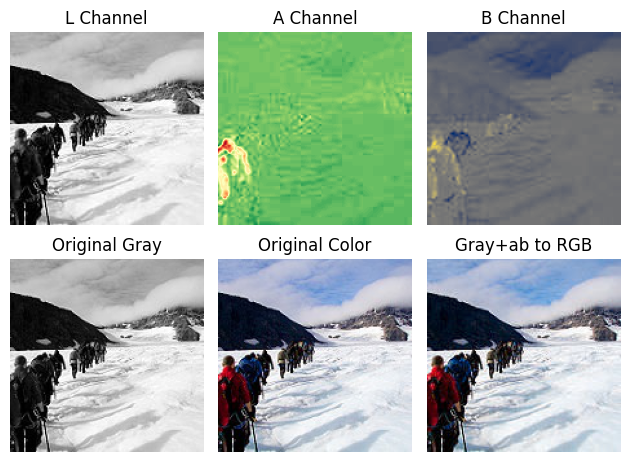

In [10]:
fig, axes = plt.subplots(2, 3)

axes[0, 0].imshow(train_set[8][2].permute(1, 2, 0), cmap='gray')
axes[0, 0].axis("off")
axes[0, 0].set_title("L Channel")

axes[0, 1].imshow(train_set[8][3][0], cmap='RdYlGn_r')
axes[0, 1].axis("off")
axes[0, 1].set_title("A Channel")

axes[0, 2].imshow(train_set[8][3][1], cmap='cividis')
axes[0, 2].axis("off")
axes[0, 2].set_title("B Channel")

axes[1, 0].imshow(train_set[8][0].permute(1, 2, 0), cmap='gray')
axes[1, 0].axis("off")
axes[1, 0].set_title("Original Gray")

axes[1, 1].imshow(train_set[8][1].permute(1, 2, 0), cmap='gray')
axes[1, 1].axis("off")
axes[1, 1].set_title("Original Color")

axes[1, 2].imshow(lab2color(train_set[8][2], train_set[8][3]), cmap='gray')
axes[1, 2].axis("off")
axes[1, 2].set_title("Gray+ab to RGB")

plt.tight_layout()
plt.show()

# img1 = lab2color(train_set[1][2], train_set[1][3], train_set[1][4])
# plt.imshow(img1, cmap='cividis')
# plt.show()

# img2 = lab2color(train_set[1][0], train_set[1][3], train_set[1][4])
# plt.imshow(img2, cmap='cividis')
# plt.show()

# print(train_set[1][3][0].shape)


# Define Your Model

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 2, kernel_size=3, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Fit The Model

Also Define optimizer, Criterion and other parameters

In [12]:
# Define hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to GPU
model = AutoEncoder().to(device)

# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)

# Train the model
for epoch in range(num_epochs):
    model.train()
    for samples, _, _, targets in train_loader:
        # Move images to GPU
        samples = samples.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(samples)
        # Compute loss
        loss = criterion(outputs, targets)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for samples, _, _, targets in validation_loader:
            # Move images to GPU
            samples = samples.to(device)
            targets = targets.to(device)
            outputs = model(samples)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {total_loss/len(validation_loader)}")

Epoch [1/30], Validation Loss: 0.0029769331061591706
Epoch [2/30], Validation Loss: 0.0025826371856965125
Epoch [3/30], Validation Loss: 0.0025348506751470268
Epoch [4/30], Validation Loss: 0.00282927385220925
Epoch [5/30], Validation Loss: 0.0025058661897977195
Epoch [6/30], Validation Loss: 0.002483608123535911
Epoch [7/30], Validation Loss: 0.0023904676005865135
Epoch [8/30], Validation Loss: 0.002385487469534079
Epoch [9/30], Validation Loss: 0.002383609573977689
Epoch [10/30], Validation Loss: 0.0022855537051024535
Epoch [11/30], Validation Loss: 0.0023665392266896865
Epoch [12/30], Validation Loss: 0.0023489192438622317
Epoch [13/30], Validation Loss: 0.0023248966705674925
Epoch [14/30], Validation Loss: 0.002251609209148834
Epoch [15/30], Validation Loss: 0.002228112561473002
Epoch [16/30], Validation Loss: 0.0021908480363587537
Epoch [17/30], Validation Loss: 0.002332791705460598
Epoch [18/30], Validation Loss: 0.0023955247597768903
Epoch [19/30], Validation Loss: 0.00219223023

# Plot The Results

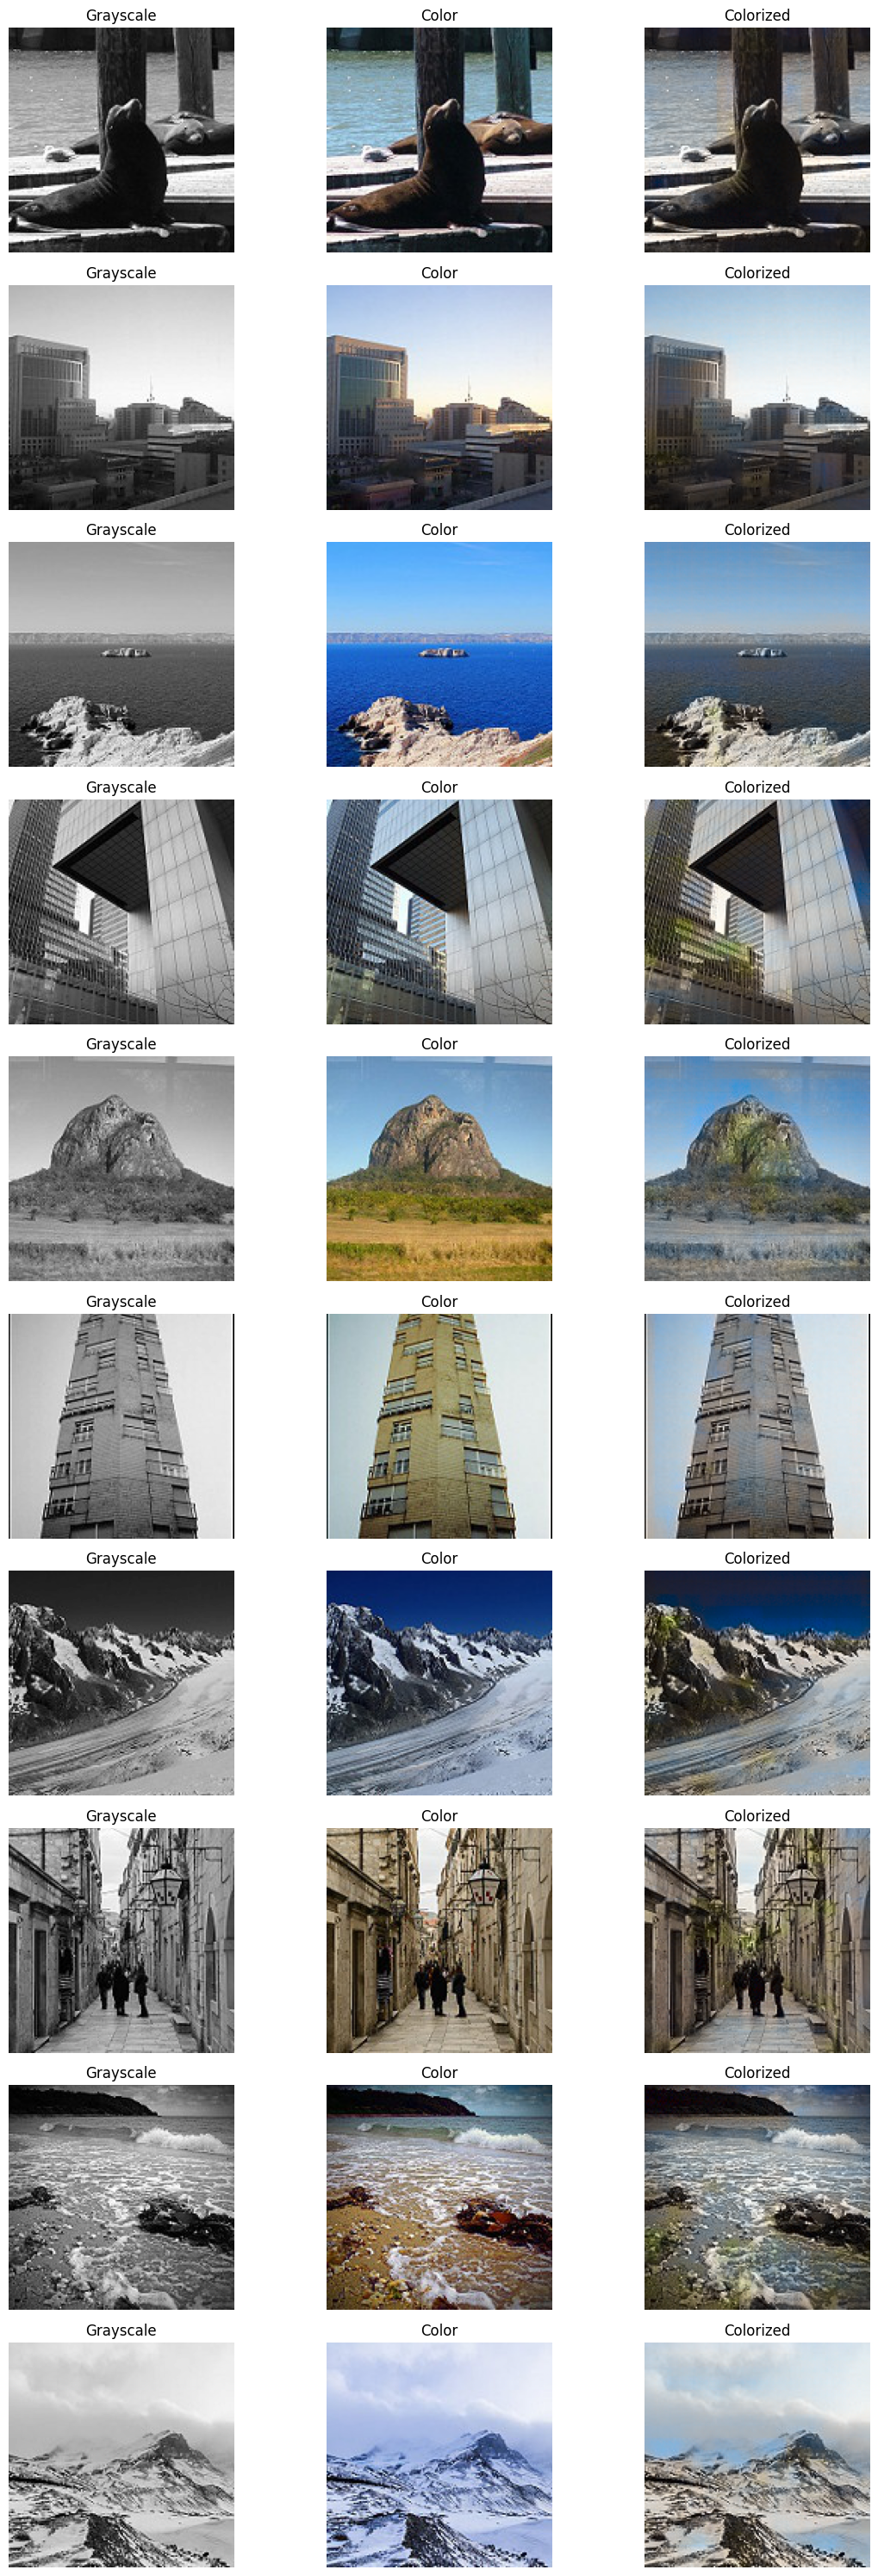

In [19]:
# Visualize grayscale images, their corresponding color images, and colorized versions
model.eval()
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10)
itr = iter(test_loader)
samples, colors, _, _ = next(itr)

with torch.no_grad():
    output = model(samples.to(device))
    output = output.to("cpu")


fig, axes = plt.subplots(10, 3, figsize=(12, 30))

for i in range(10):
    axes[i, 0].imshow(samples[i].permute(1, 2, 0), cmap='gray')
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Grayscale")

    axes[i, 1].imshow(colors[i].permute(1, 2, 0), cmap='gray')
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Color")

    axes[i, 2].imshow(lab2color(samples[i], output[i]), cmap='gray')
    axes[i, 2].axis("off")
    axes[i, 2].set_title("Colorized")

plt.tight_layout()
plt.show()
